In [ ]:
import os
import random
import string
import subprocess
from typing import List, Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

The following code shows an example of building a custom LLM-based assistant. The LLM is a 8B 6-bit-quantized Llama 3 (https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct), deployed on local LangCPP server. The main goal is to achieve complex behaviors by just using a local LLM, which can fit inside a notebook GPU (at most 8 GB memory).

In [ ]:
llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="sk-fake-key",  # Not needed but required for OpenAI compatibility,
    temperature=0.
)

response = llm.invoke("What is the capital of france?")
print(response.content)

The capital of France is Paris.


# Langgraph agent

Let's use a custom LangGraph agent for the assistant. Our selected task for the bot is a filesystem assistant, where the AI can observe some local files and folder and decide to write some contents (attention: not safe for the systen, just for demonstration purpose). Let's implement some tools for the task, and check some basic queries:

In [ ]:

WS_PATH = "workspace"

@tool
def list_directory(path: str) -> List[str]:
    """List the child nodes inside a directory."""
    try:
        if path[0] == '/':
            path = path[1:]
        return os.listdir(os.path.join(WS_PATH, path))
    except Exception as e:
        return [f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"]

@tool
def read_file(path: str) -> str:
    """Read the content of a file."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    if not os.path.exists(filepath):
        return "Error: File does not exist"
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return file.read()
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

@tool
def write_file(path: str, content: str) -> str:
    """Write some new content into a file."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    try:
        print(f"Writing to {filepath}")
        # with open(filepath, "w", encoding="utf-8") as file:
        #     file.write(content)
        return "Success: File updated."
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

@tool
def execute_main(path: str) -> str:
    """Executes a Python file."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    if not os.path.exists(filepath):
        return "Error: File does not exist."
    try:
        result = subprocess.run(["python", filepath], capture_output=True, text=True)
        return result.stdout if result.returncode == 0 else result.stderr
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

tools = [list_directory, read_file, write_file, execute_main]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

In [3]:
read_file('dummy.txt')

C:\Users\rocca\AppData\Local\Temp\ipykernel_12444\2723539149.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  read_file('dummy.txt')


'Auisa&8sva72'

In [4]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "read_file",
            "args": {"path": "dummy.txt"},
            "id": "2",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='Auisa&8sva72', name='read_file', tool_call_id='2')]}

In [5]:
llm_with_tools = llm.bind_tools(tools)

In [6]:
llm_with_tools.invoke("Read the content of the file 'dummy.txt'").tool_calls

[{'name': 'read_file',
  'args': {'path': 'dummy.txt'},
  'id': '',
  'type': 'tool_call'}]

Our goal is to be able to submit complex requests to the assistant, which could require some structured reasoning and tool usages. Therefore we will adopt a planner-based cognitive architecture for the bot:

In [ ]:
def gen_rand_id(length):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for _ in range(length))



def route_tools(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return END


def call_tool(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    for tool_call in response.tool_calls:
        tool_call['id'] = gen_rand_id(16)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("llm", call_tool)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "llm")
workflow.add_conditional_edges("llm", route_tools, ["tools", END])
workflow.add_edge("tools", "llm")

app = workflow.compile()

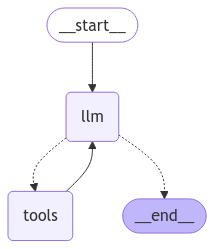

In [8]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's check the behavior for more complex queries:

In [ ]:
for chunk in app.stream(
    {"messages": [("system", "Use your tools to answer the user query."),
                  ("human", "What is the content of the file at '/dummy.txt'?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the content of the file at '/dummy.txt'?
================================== Ai Message ==================================
Tool Calls:
  read_file (F0buA8pkQ24A2pHP)
 Call ID: F0buA8pkQ24A2pHP
  Args:
    path: /dummy.txt
================================= Tool Message =================================
Name: read_file

Auisa&8sva72
================================== Ai Message ==================================

The content of the file at '/dummy.txt' is 'Auisa&8sva72'.


In [ ]:
for chunk in app.stream(
    {"messages": [("system", "Use your tools to answer the user query."),
                  ("human", "What is the content of the directory at '/subdir'?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the content of the directory at '/subdir'?
================================== Ai Message ==================================
Tool Calls:
  list_directory (tUqK8681AnembJuo)
 Call ID: tUqK8681AnembJuo
  Args:
    path: /subdir
================================= Tool Message =================================
Name: list_directory

["dummy2.txt", "dummy3.txt", "subdir2"]
================================== Ai Message ==================================

The directory at '/subdir' contains the following items: 
1. dummy2.txt
2. dummy3.txt
3. subdir2


In [ ]:
for chunk in app.stream(
    {"messages": [("system", "Use your tools to answer the user query."),
                  ("human", "What is the content of one random file inside the directory at '/subdir'?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the content of one random file inside the directory at '/subdir'?
================================== Ai Message ==================================
Tool Calls:
  list_directory (iiDBJWP37YWAur8P)
 Call ID: iiDBJWP37YWAur8P
  Args:
    path: /subdir
================================= Tool Message =================================
Name: list_directory

["dummy2.txt", "dummy3.txt", "subdir2"]
================================== Ai Message ==================================
Tool Calls:
  read_file (W356ZJtuNbRytNbY)
 Call ID: W356ZJtuNbRytNbY
  Args:
    path: /subdir/dummy2.txt
================================= Tool Message =================================
Name: read_file

AAABDISFGGD
================================== Ai Message ==================================

The content of the file 'dummy2.txt' inside the directory '/subdir' is 'AAABDISFGGD'.


In [12]:
for chunk in app.stream(
    {"messages": [("system", "Use your tools to answer the user query."),
                  ("human", "Write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt'. What was the written value?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt'. What was the written value?
================================== Ai Message ==================================
Tool Calls:
  read_file (t8mk5EpxQSrcnXxl)
 Call ID: t8mk5EpxQSrcnXxl
  Args:
    path: dummy.txt
================================= Tool Message =================================
Name: read_file

Auisa&8sva72
================================== Ai Message ==================================
Tool Calls:
  write_file (YI6Up3mRPjMXY8w1)
 Call ID: YI6Up3mRPjMXY8w1
  Args:
    path: subdir/dummy2.txt
    content: Auisa&8sva72
Writing to workspace\subdir/dummy2.txt
================================= Tool Message =================================
Name: write_file

Success: File updated.
================================== Ai Message ==================================

The content of 'dummy.txt' has been successfully written into 'subdir/

In [14]:
for chunk in app.stream(
    {"messages": [("system", "Use your tools to answer the user query."),
                  ("human", "Write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt'. Then write the content of 'subdir/dummy3.txt' into 'dummy.txt'")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt'. Then write the content of 'subdir/dummy3.txt' into 'dummy.txt'
================================== Ai Message ==================================
Tool Calls:
  read_file (N0O5kvZ2y4l4GJlP)
 Call ID: N0O5kvZ2y4l4GJlP
  Args:
    path: dummy.txt
================================= Tool Message =================================
Name: read_file

Auisa&8sva72
================================== Ai Message ==================================
Tool Calls:
  write_file (Mdb37IF0Kuy954jU)
 Call ID: Mdb37IF0Kuy954jU
  Args:
    path: subdir/dummy2.txt
    content: Auisa&8sva72
Writing to workspace\subdir/dummy2.txt
================================= Tool Message =================================
Name: write_file

Success: File updated.
================================== Ai Message ==================================
Tool Calls:
  read_file (5sJY6Vs5gcM

Please note that the presented architecture is just a baseline example for exploring the capabilities of the described architecture. In order to have a more reliable response for more complex queries, the cognitive system can be developed even more. A context-extended model can also be used to improve longer planning of the current agent, such as the Qwen2.5-7B-Instruct-1M-Q6_K model.